#### Python script for the series plots like on SIMuRG web page
##### Input data are the all dataproduct series in single HDF file downloaded from the simurg

In [6]:
import requests
import time
import h5py
import numpy as np
import sys
import matplotlib
import pytz
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import locale
from datetime import datetime, timedelta

font = {'family': 'Liberation Sans',
        "sans-serif": "Arial",
        'size': 10}

matplotlib.rc('font', **font)

### Here we assume the data are already here in data.h5 file
### You can download it [manually](https://simurg.iszf.irk.ru/documentation/how_to_web) or [via API](https://simurg.iszf.irk.ru/documentation/how_to_api) or using functions given in [some notebooks](https://simurg.iszf.irk.ru/notebooks#long-series)
### Typical link for data looks like that (Link might be broken):
https://simurg.iszf.irk.ru/tecs//media/storage/simurg/simurg/user_temp/dtec_2_10_2015_077_b8b3.h5

#### Read series in file

In [7]:
def series_generator(fname, plot_product, sats=[]):
    file = h5py.File(fname, 'r')
    for site_name in file:
        site_grp = file[site_name]
        for sat_name in site_grp:
            if sats and sat_name not in sats:
                continue
            sat_grp = site_grp[sat_name]
            products = [product for product in sat_grp]
            if plot_product not in products or 'timestamp' not in products:
                continue
            yield  {'site': site_name, 
                    'sat': sat_name,  
                    'product': plot_product,
                    'timestamp': sat_grp['timestamp'],
                    'data': sat_grp[plot_product]}

#### and ploting them nicely

In [24]:
product_name = {'roti': 'ROTI',
                'dtec_2_10': 'TEC varations with periods 2-10 minute',
                'dtec_10_20': 'TEC varations with periods 10-20 minute',
                'dtec_20_60': 'TEC varations with periods 20-60 minute',}

def plot(series, product, spacing=0.1):
    scale = 2
    fig, ax1 = plt.subplots(figsize=(3.3*scale, 3*scale), dpi=300)
    mint, maxt = None, None
    plot_ax = ax1
    xtick = []
    xlabels = []
    for i, ser in enumerate(series):
        stmp = ser['timestamp']
        t = [datetime.fromtimestamp(ts, tz=pytz.utc) for ts in stmp]
        mint = min(t) if mint is None else min(mint, min(t))
        maxt = max(t) if maxt is None else max(maxt, max(t))
        shift = i*spacing
        plot_data = np.array(ser['data'])
        plot_data[np.where(stmp - np.roll(stmp, 1) > 120)] = None
        plot_ax.plot(t, plot_data + shift, label=ser['sat'], linewidth=1)
        if i % 2 == 0:
            xtick.append(shift)
            xlabels.append(ser['sat'])




    for i, ser in enumerate(series):
        plot_ax.hlines(spacing * i, mint, maxt, colors='k', linestyles='dashed', linewidth=0.25)
    locale.setlocale(locale.LC_ALL,'en_US.utf8')
    plt.title('{} for {}\n {} - {}'.format(product_name[product],
                                           series[0]['site'], 
                                           mint.strftime("%d %b %Y"), 
                                           maxt.strftime("%d %b %Y")),
              fontsize=10)
    plot_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.yticks(xtick, xlabels)
    #plt.legend()
    plt.show()


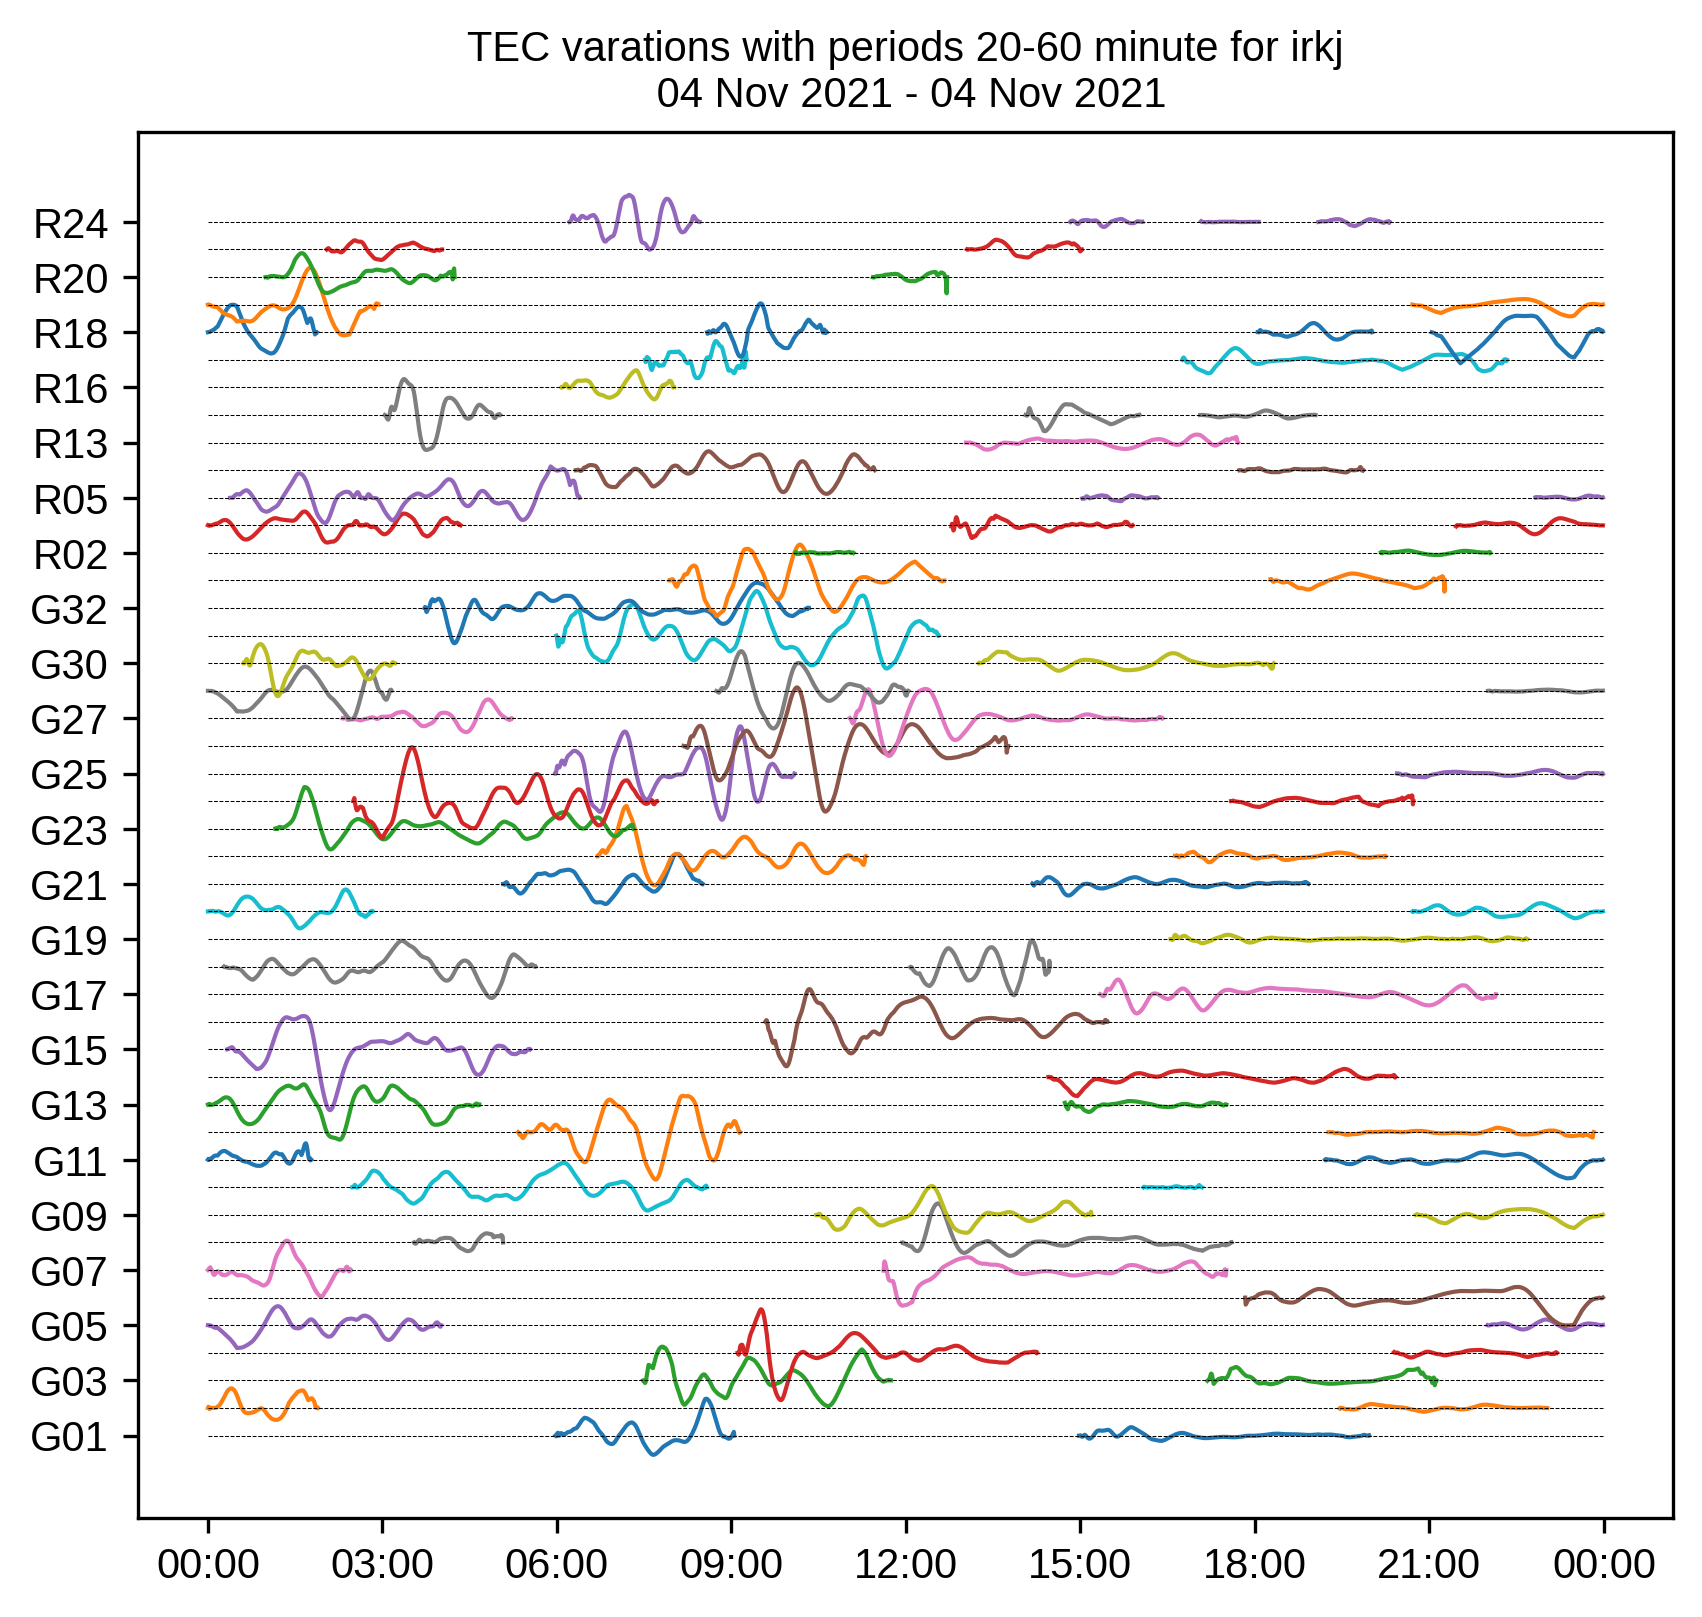

In [25]:
product = 'dtec_20_60'
fname = '/tmp/simurg_data/data_637490595fc226bd8cca4890.h5'
series = [ser for ser in series_generator(fname, product)]
plot(series, product, spacing=0.5)